# Importing libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

In [4]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

# Importing Data

In [6]:
#start_date=datetime.datetime(2020,1,1)
start_date=datetime.datetime(2024,1,1)
today=datetime.datetime.today()

In [7]:
days=(today-start_date).days
days

412

In [8]:
remaining=days%500
numbers_of_table=days//500

In [9]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:30].to_list()

In [10]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(days))
data=Binance.get_price(tickers,temp_end)
omusdt=Binance.get_price(['OMUSDT'],temp_end)
prices=prices.combine_first(data)
prices=prices.sort_index()
prices = prices[~prices.index.duplicated(keep='first')]
prices['OMUSDT']=omusdt

In [11]:
returns=np.log(1+prices.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()

In [12]:
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)

In [13]:
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

# Strategy Backtesting

In [15]:
month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

In [16]:
returns_to_use

,AAVEUSDT,ADAUSDT,APTUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,DOTUSDT,ETCUSDT,...,SHIBUSDT,SOLUSDT,SUIUSDT,TRXUSDT,UNIUSDT,USDCUSDT,WBETHUSDT,WBTCUSDT,XLMUSDT,XRPUSDT
2023-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01,0.066555,0.047988,0.056940,0.084284,0.030713,0.005437,0.043863,0.026883,0.046803,0.026116,...,0.030421,0.077438,0.084794,0.000743,0.051016,-0.0004,0.030269,0.045063,0.022990,0.022170
2024-01-02,-0.052032,-0.029639,0.031569,-0.032226,-0.040775,-0.004155,0.017220,-0.009722,-0.021640,-0.023837,...,-0.011300,-0.029360,0.071345,0.005739,-0.057545,-0.0002,0.002013,0.016608,-0.022215,-0.007656
2024-01-03,-0.071600,-0.082843,-0.124198,-0.098516,-0.094144,0.011465,-0.047888,-0.105117,-0.097977,-0.092447,...,-0.098440,-0.080043,-0.071463,-0.014785,-0.109162,-0.0002,-0.063265,-0.048516,-0.068938,-0.070126
2024-01-04,0.010754,0.023075,0.130225,0.050858,0.023232,0.024708,0.030024,0.024095,0.032638,0.021729,...,0.042951,0.062843,0.011549,0.001965,0.014966,-0.0004,0.024235,0.029659,0.009087,0.007698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-12,0.036495,0.027382,0.044895,0.042412,0.034696,0.081925,0.021605,0.043044,0.083348,0.055784,...,0.080190,-0.005979,0.073608,0.009498,0.058987,-0.0003,0.050467,0.020556,0.046077,0.024681
2025-02-13,0.014179,0.013661,-0.001627,-0.042412,-0.023891,-0.047319,-0.012977,-0.006570,-0.018537,-0.011289,...,-0.042662,-0.012940,-0.032487,-0.038120,-0.006250,0.0001,-0.023036,-0.011159,0.011937,0.034374
2025-02-14,0.023853,-0.013536,-0.006536,0.038630,0.019217,-0.007566,0.009194,0.035006,0.007572,0.011757,...,0.026054,0.026117,0.024358,-0.011596,0.016746,0.0000,0.019059,0.008299,0.039266,0.067406
2025-02-15,-0.035780,-0.023659,-0.016529,-0.035091,-0.025506,0.003782,0.000709,-0.000221,-0.029044,-0.027971,...,-0.024214,-0.024933,-0.038823,0.025588,-0.024665,-0.0001,-0.011886,0.000214,-0.004861,0.008545


In [17]:
results={}
btc_limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0]
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]
om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

In [18]:
for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                        {'type': 'eq', 'fun': lambda weights: weights[om_limit]-0.5}])
        
        
        results[date]=np.round(optimal,6)

    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T

In [19]:
tracking={}
portfolio={}
investment_amount=1000
initial_amount=investment_amount
perf=dataframe.pct_change()
transaction_fee=0.005

weight_dict={col: 1/returns_to_use.shape[1] for col in returns_to_use.columns}


for i in range(len(dates_end)-1):
    
    print(dates_end[i],investment_amount,investment_amount/initial_amount)

    
    temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
    initial_price=temp.iloc[0].to_dict()

    if dates_end[i]>dates_end[0]:

        top50=rolling_optimization.loc[dates_end[i]]
        top50_dict=rolling_optimization.loc[dates_end[i]].to_dict()
        weight_dict={}

        for key in temp.columns:

            if key in top50_dict: 
                weight_dict[key]=top50_dict[key]
            else:
                weight_dict[key]=0
      
                
    weight_vec=np.array(list(weight_dict.values()))
    
    inital_investment_per_stock={}
    shares={}

    for col in temp.columns:
        
        weighted_perf=weight_vec*perf.loc[dates_end[i]]
        
        inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
        shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

    tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

    temp=temp*shares    
    portfolio[dates_end[i]]=temp
    investment_amount=temp.iloc[-1].sum()
    

temp=dataframe.loc[dates_end[-2]:]*shares
portfolio[dates_end[-1]]=temp

2024-01-31 00:00:00 1000 1.0
2024-02-29 00:00:00 1373.8554665544648 1.3738554665544649
2024-03-29 00:00:00 2529.2349335298286 2.5292349335298288
2024-04-30 00:00:00 1997.8501118870627 1.9978501118870626
2024-05-31 00:00:00 1937.743113383508 1.937743113383508
2024-06-28 00:00:00 2061.3339445139513 2.0613339445139514
2024-07-31 00:00:00 2792.373637208128 2.792373637208128
2024-08-30 00:00:00 2763.4305597131925 2.7634305597131923
2024-09-30 00:00:00 3181.8470146739046 3.1818470146739046
2024-10-31 00:00:00 3513.3173952602256 3.5133173952602257
2024-11-29 00:00:00 6370.12284501686 6.37012284501686
2024-12-31 00:00:00 6371.352982059771 6.371352982059771
2025-01-31 00:00:00 8326.58309300595 8.326583093005949
2025-02-15 00:00:00 9656.823524690666 9.656823524690665


In [20]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])

In [21]:
historical_portfolio.sum(axis=1)

2024-01-31      973.183465
2024-02-01      983.954782
2024-02-02     1003.717789
2024-02-03     1008.139119
2024-02-04     1001.424496
                  ...     
2025-02-12     8528.647011
2025-02-13     8377.353957
2025-02-14     9252.954501
2025-02-15     9656.823525
2025-02-16    10066.366815
Length: 383, dtype: float64

<Axes: >

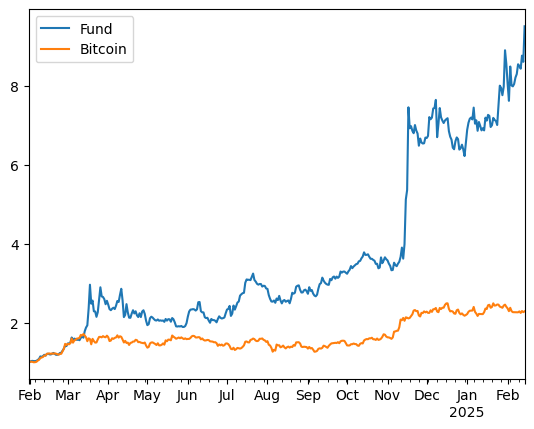

In [22]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.iloc[:-2]).cumprod().plot()

In [23]:
years=sorted(list(set(performance.index.year)))

month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

<Axes: >

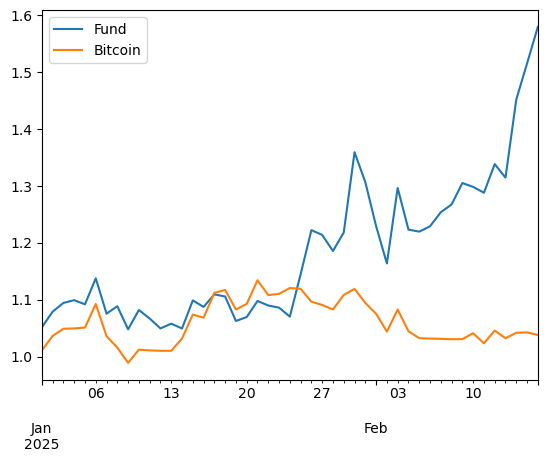

In [66]:
(1+performance_pct.loc['2025':]).cumprod().plot()

In [25]:
year_returns={}
for year in years:

    perf_year=performance.loc[str(year)].iloc[-1]/performance.loc[str(year)].iloc[0]-1
    year_returns[year]=perf_year

year_returns[years[-1]]=performance.loc[str(years[-1])].iloc[-2]/performance.loc[str(years[-1])].iloc[0]-1

In [26]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2024,2025
Fund,5.546919,0.441362
Bitcoin,1.197651,0.031481


In [27]:
month_returns={}
for month in month_year:

    perf_year=performance.loc[str(month)].iloc[-1]/performance.loc[str(month)].iloc[0]-1
    month_returns[month]=perf_year

month_returns[month]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-1])].iloc[0]-1

In [28]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe

,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02
Fund,0.0,0.396259,0.733076,-0.165192,0.026170,0.039683,0.228680,-0.020163,0.195765,0.113766,0.869211,-0.019648,0.242813,0.232710
Bitcoin,0.0,0.418914,0.142529,-0.128899,0.157201,-0.073706,0.027472,-0.097623,0.105158,0.156009,0.387245,-0.037137,0.082859,-0.030466


In [29]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['Bitcoin']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['Bitcoin'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['Bitcoin'].iloc[-2]/performance['Bitcoin'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(returns_to_use.index.year)))/metrics['Fund Vol']

In [30]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.709952
Fund Vol,0.770195
Bench Vol,0.428198
Fund Return,9.922922
Bench Return,2.291443
Sharpe Ratio,2.880794


In [31]:
tracking[dates_end[-2]][0]

{'AAVEUSDT': 0.0,
 'ADAUSDT': 0.043933,
 'APTUSDT': 0.0,
 'AVAXUSDT': 0.0,
 'BCHUSDT': 0.0,
 'BNBUSDT': 0.273324,
 'BTCUSDT': 0.0,
 'DOGEUSDT': 0.0,
 'DOTUSDT': 0.0,
 'ETCUSDT': 0.0,
 'ETHUSDT': 0.0,
 'HBARUSDT': 0.0,
 'ICPUSDT': 0.0,
 'LINKUSDT': 0.0,
 'LTCUSDT': 0.0,
 'NEARUSDT': 0.0,
 'OMUSDT': 0.5,
 'PEPEUSDT': 0.0,
 'SHIBUSDT': 0.0,
 'SOLUSDT': 0.0,
 'SUIUSDT': 0.0,
 'TRXUSDT': 0.182743,
 'UNIUSDT': 0.0,
 'USDCUSDT': 0.0,
 'WBETHUSDT': 0.0,
 'WBTCUSDT': 0.0,
 'XLMUSDT': 0.0,
 'XRPUSDT': 0.0}